In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import pandas as pd
import shutil

import sys
sys.path.append('..')

from lib.ChurnEnsemble import ChurnEnsemble

SEED = 42
np.random.seed(SEED)

2024-06-30 20:01:08.812937: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
params = dict(
    wtte=dict(
        features=[
            'plan', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
            'failed', 'usage', 'usage_groups', 'usage_payments', 'momentum'
        ],
        params={}
    ),
    xgb=dict(
        features=[
            'employees', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
            'plan', 'usage', 'usage_groups', 'usage_payments', 'usage_avg',
            'paid_periods', 'months', 'failed_ratio', 'momentum'
        ],
        params={}
    )
)

min_tte = 1  # Minimum time to event for binary classification (positive if `tte` <= `min_tte`)
max_sl = 24  # Maximum sequence length (0 = max length from data)
test_size = 0.25  # Percentage of the data to use for test/validation

In [3]:
data = pd.read_csv('../files/churn-data-fit.csv')

data

,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,momentum,months,failed_ratio,usage_diff
0,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,1.0,0.00,4.0,NaN,0.00
1,51b46d18c4de615d0f000019,1,2017-08-01,5.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,2.0,1.20,5.0,NaN,0.00
2,51b46d18c4de615d0f000019,1,2017-09-01,6.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,2.00,0.0,0.0,1.0,0.0,3.0,-3.14,6.0,0.0,0.00
3,51b46d18c4de615d0f000019,1,2017-10-01,7.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,1.75,0.0,0.0,1.0,0.0,3.0,-13.60,7.0,0.0,-0.75
4,51b46d18c4de615d0f000019,1,2017-11-01,8.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,1.60,0.0,0.0,1.0,0.0,3.0,-18.57,8.0,0.0,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201230,66633bcee489710bb6afe3d9,11065,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,101.97,101.97,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201231,666346aee489710bb6afead3,11066,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,40.00,40.00,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201232,66634aea1e0bd65a73bf4f2f,11067,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,46.62,46.62,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201233,666388b3e489710bb6b00925,11068,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,60.19,60.19,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00


In [4]:
# Clean previous data path
if os.path.exists('../files/ensemble'):
    shutil.rmtree('../files/ensemble')

# Instantiate Ensemble model, set parameters and data
model = ChurnEnsemble(
    min_tte=min_tte,
    max_sl=max_sl,
    seed=SEED,
    verbose=1,
    path='../files/ensemble',
    **params
).set_data(
    data,
    test_size=test_size
).build_model()

model.get_params()

Total Customers: 11.069 | Censored: 2.678 | Non-censored: 8.391 | Censored Rate 24,19%
Train: 8.301 (24,19%) | Test: 2.768 (24,21%)


{'wtte': {'nn': 0,
  'hl': 2,
  'lr': 0.0001,
  'epochs': 200,
  'batch': 512,
  'lr_decay': 0,
  'stop': 0,
  'dropout': 0.1,
  'weight_l1': 0,
  'weight_l2': 1e-05,
  'init_alpha': None,
  'max_beta': 2.0,
  'shuffle': False,
  'epsilon': 1e-08},
 'xgb': {'n': 200,
  'lr': 0.01,
  'max_depth': 16,
  'stop': 0,
  'metric': 'auc',
  'min_child_weight': 1,
  'gamma': 0,
  'weight_l1': 0,
  'weight_l2': 1,
  'dropout': 0.2,
  'shuffle': False,
  'reg_unb': True}}

In [5]:
# Fit WTTE model
model.fit_wtte()

discrete -> Max Length: 24 | Mask: -6.44
Alpha Mean: 8.75 | Beta Mean: 0.63
Init Alpha: 9.24 | Max Beta: 2.00


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 11)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 24)       │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 24)       │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 2)        │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, None, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,306 (32.45 KB)

 Trainable params: 8,306 (32.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 3.0534 - val_loss: 2.6719
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.8336 - val_loss: 2.4725
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.6750 - val_loss: 2.3579
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5887 - val_loss: 2.2909
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2.4949 - val_loss: 2.2461
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 2.4353 - val_loss: 2.2142
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 2.3961 - val_loss: 2.1916
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 2.3583 - val_loss: 2.1748
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 2.3469 - val_loss: 2.1612
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.3264 - val_loss: 2.1503
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.3057 - val_loss: 2.1409
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/ste

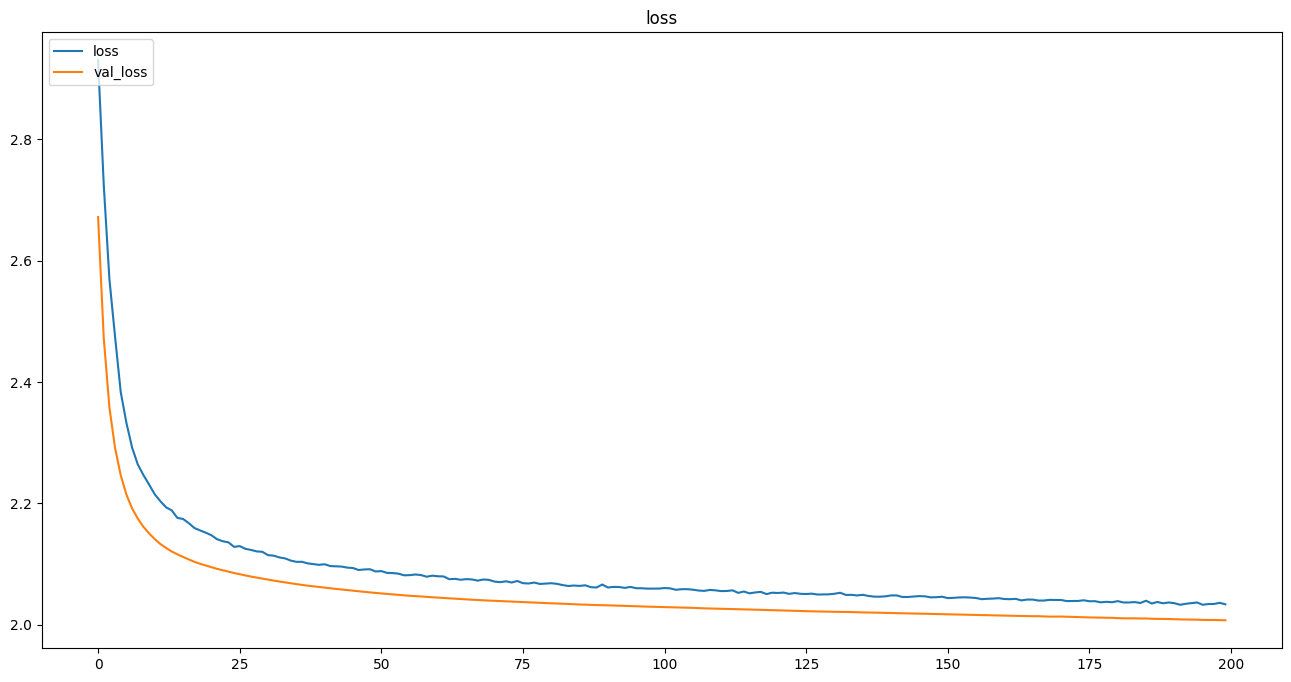

In [6]:
# Plot training history
model.wtte.plot_history_eval()

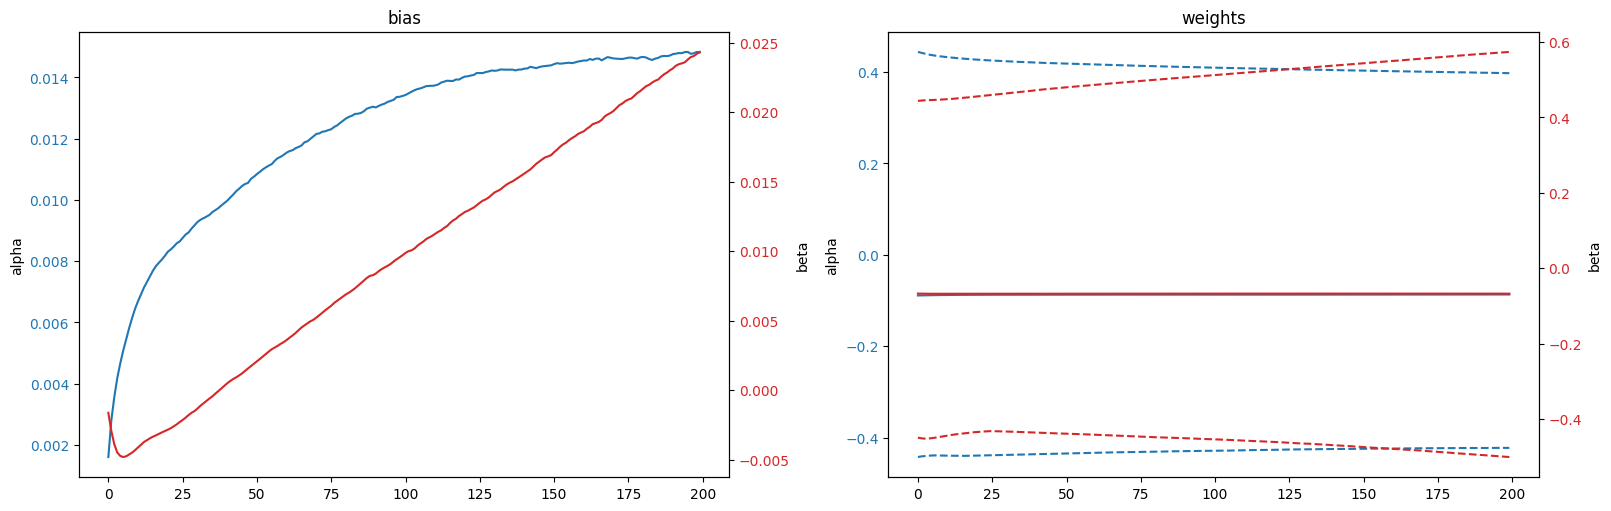

In [7]:
# Plot training weights
model.wtte.plot_weights()

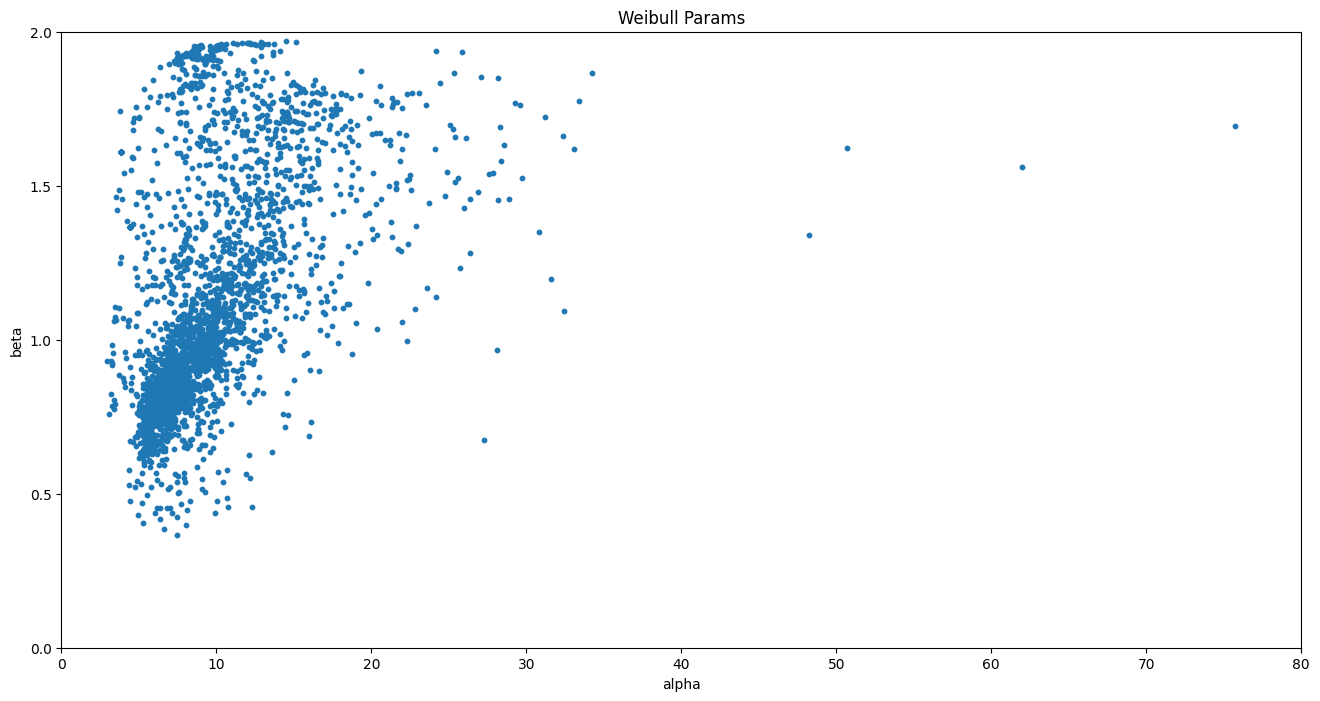

In [8]:
# Plot parameters distribution
model.wtte.plot_params_dist(model.wtte.results, loc=-1)

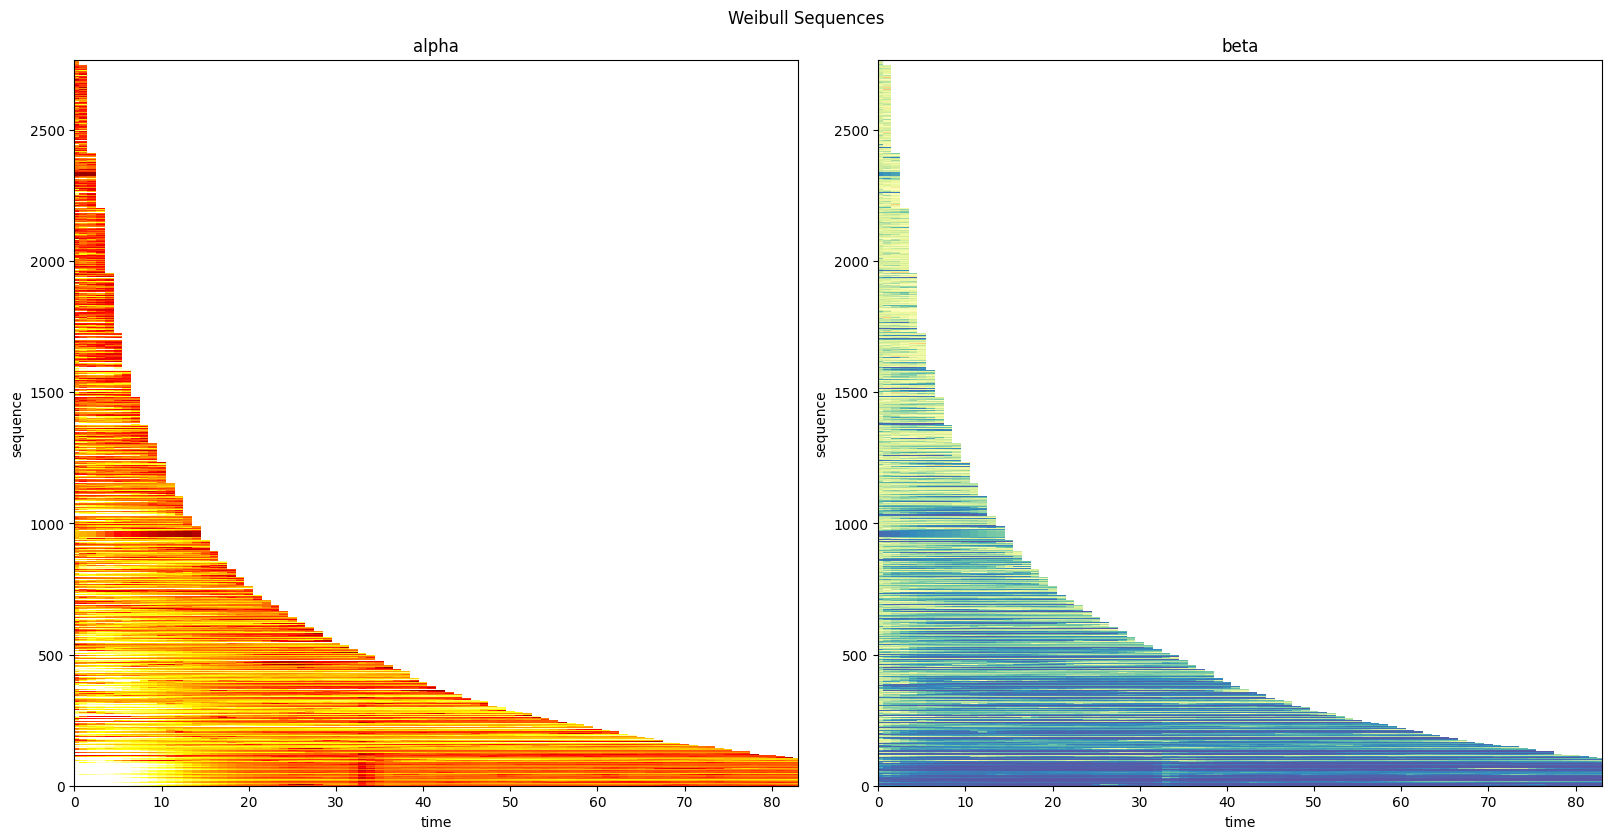

In [9]:
# Plot each customer Weibull alpha and beta parameters over time
model.wtte.plot_params_seq(model.wtte.results)

In [10]:
# Fit XGBoost model
model.fit_xgb()

2544/2544 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
[0]	validation_0-auc:0.92474	validation_1-auc:0.82617
[1]	validation_0-auc:0.94793	validation_1-auc:0.84415
[2]	validation_0-auc:0.95689	validation_1-auc:0.85169
[3]	validation_0-auc:0.95973	validation_1-auc:0.85740
[4]	validation_0-auc:0.96219	validation_1-auc:0.86105
[5]	validation_0-auc:0.96268	validation_1-auc:0.86293
[6]	validation_0-auc:0.96382	validation_1-auc:0.86402
[7]	validation_0-auc:0.96467	validation_1-auc:0.86662
[8]	validation_0-auc:0.96547	validation_1-auc:0.86707
[9]	validation_0-auc:0.96578	validation_1-auc:0.86831
[10]	validation_0-auc:0.96597	validation_1-auc:0.86939
[11]	validation_0-auc:0.96668	validation_1-auc:0.86982
[12]	validation_0-auc:0.96703	validation_1-auc:0.87018
[13]	validation_0-auc:0.96740	validation_1-auc:0.86989
[14]	validation_0-auc:0.96769	validation_1-auc:0.87055
[15]	validation_0-auc:0.96781	validation_1-auc:0.87119
[16]	validation_0-auc:0.96811	validation_1-auc:0.87212
[17]	validation_0-auc:0.96805	v

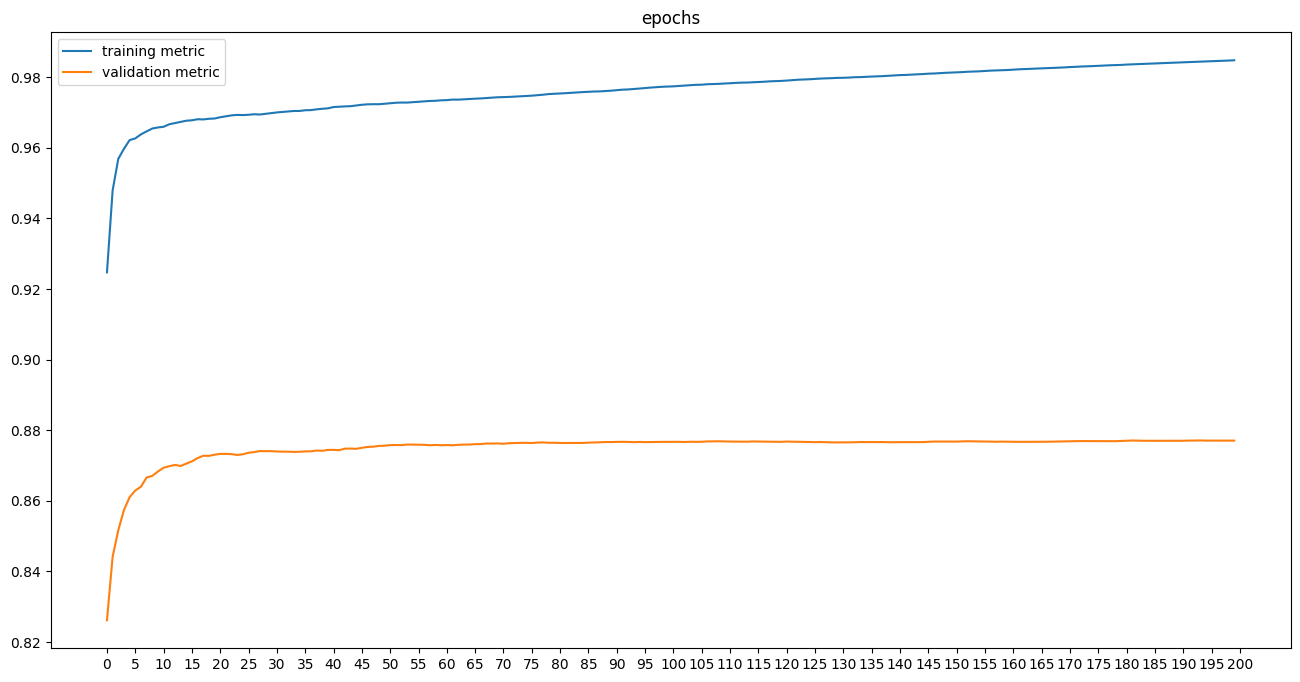

In [11]:
# Plot training history
model.xgb.plot_history_eval()

In [12]:
# Set model results from XGBoost predictions
model.set_results()
# Compute and set model scores
model.set_scores()

model.results

,id,tfs,pred,true,tgt,segment,wa,wb,momentum,cid
0,9,4,0.293939,0.0,0,2,23.666100,1.550317,0.00,51f5447aa4dcd3245d000036
1,9,5,0.323712,0.0,0,3,24.335022,1.520953,0.38,51f5447aa4dcd3245d000036
2,9,6,0.221062,0.0,0,2,23.734524,1.539890,0.32,51f5447aa4dcd3245d000036
3,9,7,0.145035,1.0,0,1,22.308653,1.576649,-0.70,51f5447aa4dcd3245d000036
4,9,8,0.713763,1.0,1,5,18.161264,1.417673,-6.75,51f5447aa4dcd3245d000036
...,...,...,...,...,...,...,...,...,...,...
50570,11062,0,0.583154,0.0,1,4,10.193367,1.011032,0.00,6661e576a98733f247acc46c
50571,11063,0,0.589781,0.0,1,4,7.249815,0.956884,0.00,6661e7dfa98733f247acc5cd
50572,11064,0,0.717192,0.0,1,5,7.052090,0.967755,0.00,666227321e0bd65a73be6c31
50573,11065,0,0.645647,0.0,1,4,7.914789,0.985070,0.00,66633bcee489710bb6afe3d9


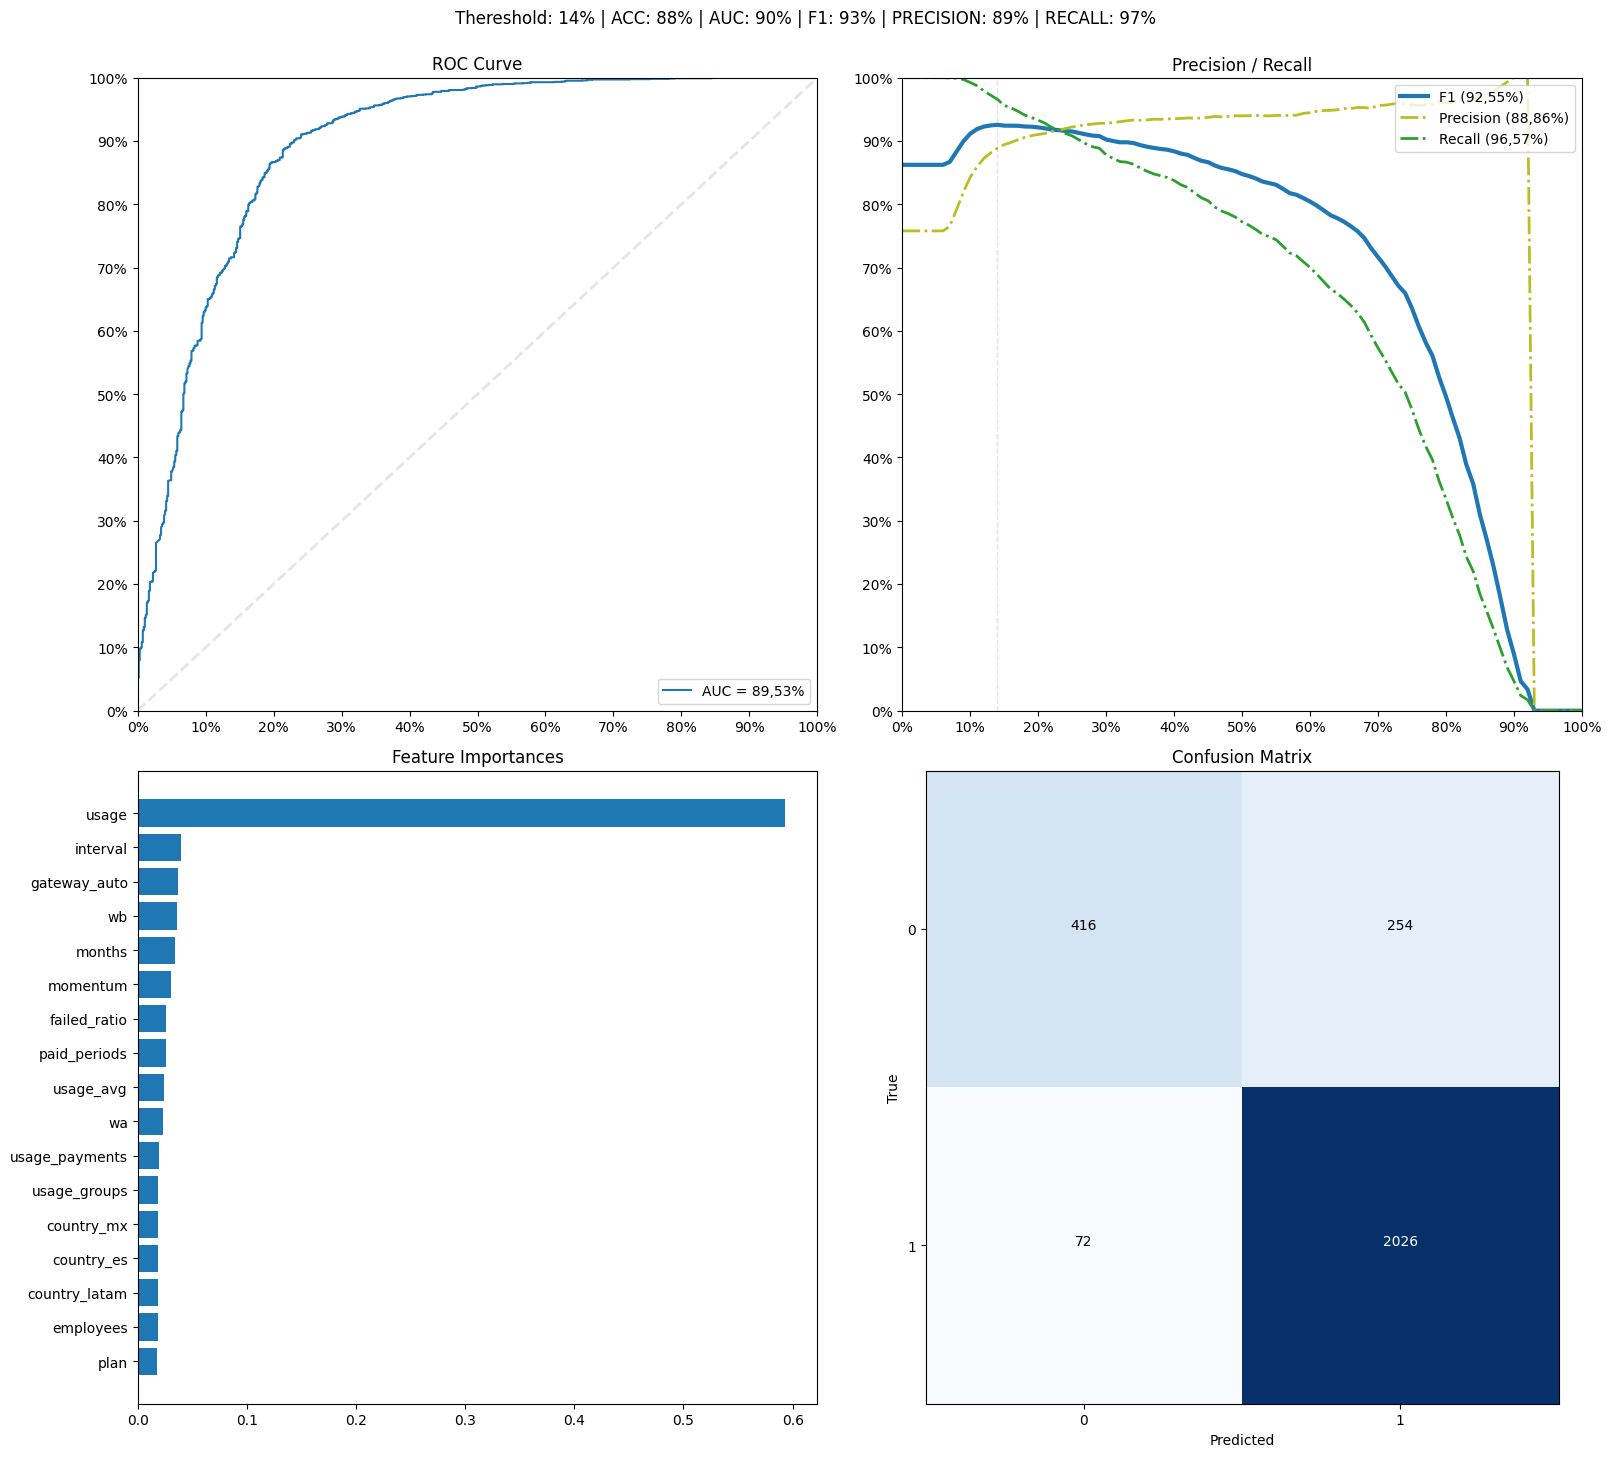

In [13]:
model.save()

# Plot scores summary
model.plot_scores()

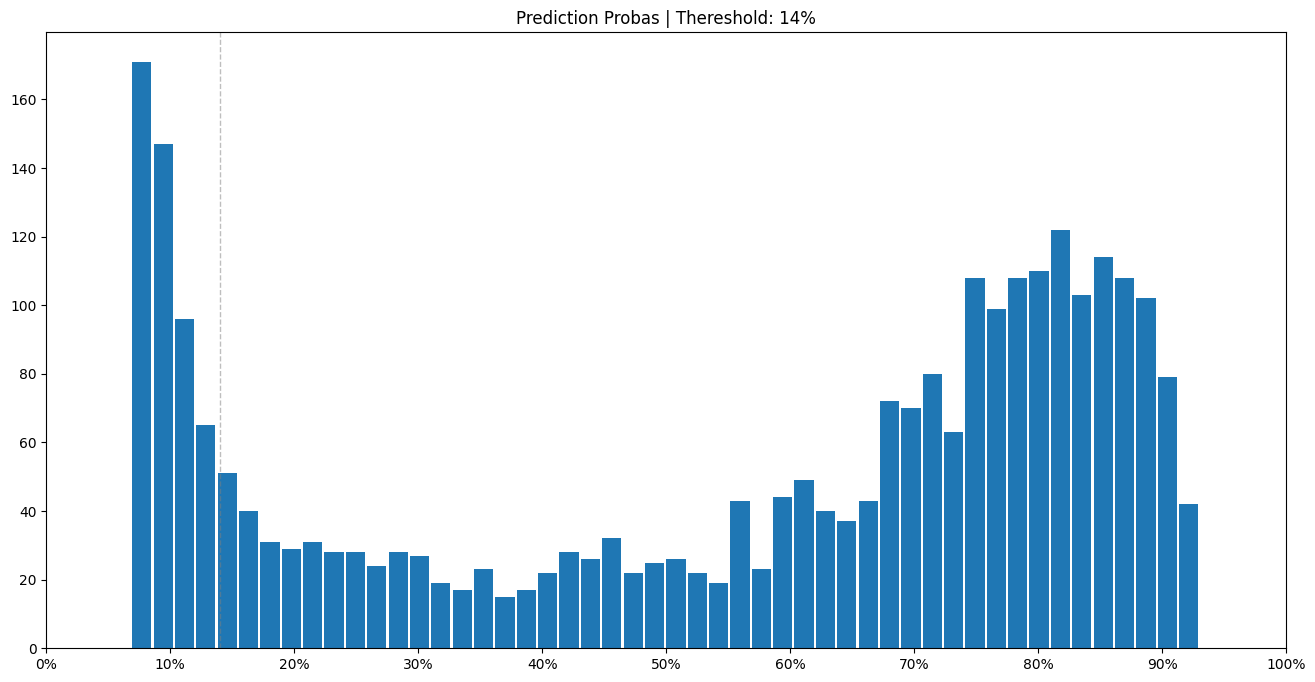

In [14]:
# Plot histogram of predicted probabilities for each customer sequence
model.plot_histogram()